Applying the correct transformation this time:

In [1]:
import sympy
sympy.init_printing()
import numpy
import pylab
import scipy.optimize
import matplotlib

# Governing Equations

Mass conservation

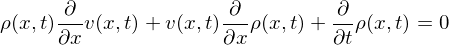

In [2]:
rho = sympy.Function('rho') # Density
v = sympy.Function('v') # Velocity
t = sympy.Symbol('t') # Time
x = sympy.Symbol('x') # Position
mass_conservation = sympy.Eq(sympy.Derivative(rho(x,t), t)+ sympy.Derivative(rho(x,t)*v(x,t),x),0).doit()
mass_conservation

Momentum conservation

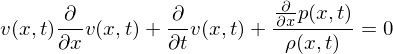

In [3]:
p = sympy.Function('p') # Pressure
momentum_conservation = sympy.Eq(sympy.Derivative(v(x,t),t)+v(x,t)*sympy.Derivative(v(x,t),x)+sympy.Derivative(p(x,t),x)/rho(x,t),0).doit()
momentum_conservation

Entropy conservation

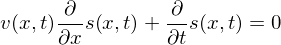

In [4]:
s = sympy.Function('s') # Entropy
entropy_conservation = sympy.Eq(sympy.Derivative(s(x,t),t)+v(x,t)*sympy.Derivative(s(x,t),x),0).doit()
entropy_conservation

Equation of state

In [5]:
gamma = sympy.Symbol('gamma') # Adiabatic index
eos = sympy.Eq(s(x,t), sympy.log(p(x,t))-gamma*sympy.log(rho(x,t)))
eos

# Reduction to dimensionless equations

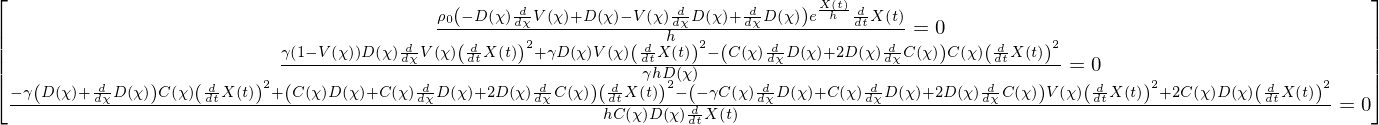

In [6]:
D = sympy.Function('D') # Dimensionless density
k = sympy.Symbol('k', positive=True) # density constant
rho_0 = sympy.Symbol('rho_0', positive=True) # density constant
h = sympy.Symbol('h') #scale height
omega = sympy.Symbol('omega') #density power law paraemter
X = sympy.Function('X') # Position of the shock front
c = sympy.Function('c') # Speed of sound
V = sympy.Function('V') # Dimensionless velocity
C = sympy.Function('C') # Dimensionless speed of sound 
chi = sympy.Symbol('chi') # Dimensionless position
delta = sympy.Symbol('delta', negative=True) # Shock velocity position power law index
temp = sympy.Matrix([mass_conservation, momentum_conservation, entropy_conservation])
temp = temp.subs(eos.lhs,eos.rhs).doit()
temp = temp.subs(p(x,t), rho(x,t)*c(x,t)**2/gamma)
temp = temp.subs(rho(x,t), rho_0*sympy.exp(X(t)/h)*D((X(t)-x)/h))
temp = temp.subs(v(x,t), X(t).diff(t)*V((X(t)-x)/h))
temp = temp.subs(c(x,t), X(t).diff(t)*C((X(t)-x)/h))
temp = temp.subs(sympy.solve(chi - (X(t)-x)/h,x,dict=True)[0])
temp = temp.doit()
temp.simplify()
temp = temp.subs(X(t).diff(t,2), delta*X(t).diff(t)**2/h/delta)
dimensionless_equation = temp
dimensionless_equation

solving for the derivatives

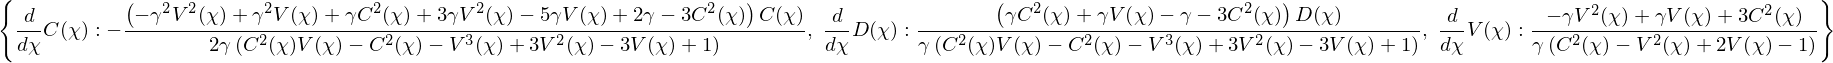

In [7]:
dimles_derivatives = sympy.solve(dimensionless_equation, [v(chi).diff(chi) for v in [D,C,V]])
dimles_derivatives #nothing...

Safe places to cross the sonic line

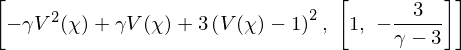

In [8]:
temp = V(chi).diff(chi).subs(dimles_derivatives)
temp = sympy.fraction(temp)[0]
temp = temp.subs(C(chi), 1-V(chi)).simplify()
[temp, sympy.solve(temp, V(chi))] #Nice!

Formulas for V_shock, C_shock:

In [9]:
V_sonic = 3/(3-gamma)
C_sonic = -gamma/(3-gamma)

It is possible to reduce these ODEs in $\chi$ to just one ode of $C$ vs $V$

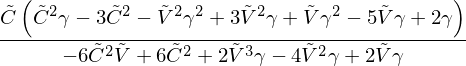

In [10]:
V_tilde = sympy.Symbol(r'\tilde{V}')
C_tilde = sympy.Symbol(r'\tilde{C}')
temp = C(chi).diff(chi)/V(chi).diff(chi)
temp = temp.subs(dimles_derivatives)
temp = temp.subs(V(chi), V_tilde)
temp = temp.subs(C(chi), C_tilde)
temp = temp.simplify()
dCdV = temp
dCdV #no delta...

Slope at the safe sonic point crossing

In [ ]:
alpha = sympy.Symbol('alpha', positive=True) # Slope
DeltaV = sympy.Symbol(r'\Delta V', positive=True)
temp = dCdV.subs(C_tilde,C_sonic+alpha*DeltaV)
temp = temp.subs(V_tilde, V_sonic+DeltaV)
temp = sympy.fraction(temp)
temp = [sympy.diff(temp[0],DeltaV,3).subs(DeltaV,0).simplify(),
        sympy.diff(temp[1],DeltaV,3).subs(DeltaV,0).simplify()]
temp = temp[0]/temp[1]
sonic_line_slope = sympy.solve(alpha-temp,alpha)[0]
sonic_line_slope

In [ ]:
sonic_slope = sonic_line_slope.subs({gamma:1.1,delta:-1.2})
sonic_slope

Boundary conditions at the shock front

In [ ]:
V_shock_front = 2/(gamma+1)
V_shock_front

In [ ]:
C_shock_front = sympy.sqrt(2*gamma*(gamma-1))/(gamma+1)
C_shock_front

# Shooting method

In [ ]:
def shoot_from_sonic_point_case_1(dv, gv):
    
    assert(gv<3)
    
    sonic_slope = sonic_line_slope.subs({gamma:gv,delta:dv})
    dV_init = 1e-6
    V_start = float(V_sonic.subs(gamma,gv)) + dV_init
    C_start = float(C_sonic.subs(gamma,gv)) + dV_init * float(sonic_slope)
    v_list = numpy.linspace(V_start, 10*V_start, 10000)
    c_list = C_start*numpy.ones_like(v_list)
    
    deriv = dCdV.subs({gamma:gv,delta:dv})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    
    for n in range(1,len(v_list)):
        delta_v = v_list[n] - v_list[n-1]
        c_list[n] = c_list[n-1] + delta_v*wrapper(v_list[n-1], c_list[n-1])
        
    # Continue beyond the portal
    vbc = float(V_shock_front.subs(gamma,gv))
    v_list_2 = numpy.linspace(-v_list[-1], vbc,10000)
    c_list_2 = -c_list[-1]*numpy.ones_like(v_list_2)
    for n in range(1, len(v_list_2)):
        delta_v = v_list_2[n] - v_list_2[n-1]
        c_list_2[n] = c_list_2[n-1] + delta_v*wrapper(v_list_2[n-1], c_list_2[n-1])
    unified_v_list = numpy.concatenate((v_list, [numpy.nan], v_list_2))
    unified_c_list = numpy.concatenate((c_list, [numpy.nan], c_list_2))
    
    return numpy.vstack((unified_v_list, unified_c_list))

my_gamma = 1.4
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-0.9,-0.7,5):
    temp = shoot_from_sonic_point_case_1(dvalue, my_gamma)
    pylab.plot(temp[0], temp[1], linewidth=1, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], 1-temp[0], 'k', linewidth=4)
pylab.scatter([float(V_shock_front.subs(gamma, my_gamma))],
           [float(C_shock_front.subs(gamma, my_gamma))], c='k', marker='o', s=50, label='front')
pylab.legend(loc='best')
pass

In [ ]:
def shoot_from_sonic_point_case_2(dv, gv):
    
    assert(gv>3)
    
    dV_init = 1e-6
    sonic_slope = sonic_line_slope.subs({gamma:gv,delta:dv})
    V_start = float(V_sonic.subs(gamma,gv)) + dV_init
    C_start = float(C_sonic.subs(gamma,gv)) + dV_init * float(sonic_slope)
    vbc = float(V_shock_front.subs(gamma,gv))
    v_list = numpy.linspace(V_start, vbc, 10000)
    c_list = C_start*numpy.ones_like(v_list)
    
    deriv = dCdV.subs({gamma:gv,delta:dv})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    
    for n in range(1,len(v_list)):
        delta_v = v_list[n] - v_list[n-1]
        c_list[n] = c_list[n-1] + delta_v*wrapper(v_list[n-1], c_list[n-1])
    
    return numpy.vstack((v_list, c_list))

my_gamma = 3.5
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-0.95,-0.51, 5):
    temp = shoot_from_sonic_point_case_2(dvalue, my_gamma)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], 1-temp[0], 'k', linewidth=4, label='sonic')
pylab.scatter([float(V_shock_front.subs(gamma, my_gamma))],
           [float(C_shock_front.subs(gamma, my_gamma))], c='k', marker='X', s=50, label='front', zorder=3)

pylab.xlabel(r'$\tilde{V}$')
pylab.ylabel(r'$\tilde{C}$')
pylab.tight_layout()
pylab.legend(loc='best')
pass

In [ ]:
#gamma_list = numpy.linspace(1.03,1.9,5)
gamma_list = numpy.linspace(1.4,1.4,1)
print(gamma_list)

delta_list = numpy.zeros_like(gamma_list)
for n, gamma_value in enumerate(gamma_list):
    function_for_bisection = lambda dvalue: shoot_from_sonic_point_case_1(dvalue, gamma_value)[1][-1] - float(C_shock_front.subs(gamma,gamma_value))
    delta_list[n] = scipy.optimize.bisect(function_for_bisection, -3,-0.1)

In [ ]:
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
pylab.plot(gamma_list, delta_list, '.')
pylab.xlabel(r'$\gamma$')
pylab.ylabel(r'$\delta$')
pylab.tight_layout()
pass

In [ ]:
gamma_list_2 = numpy.linspace(2.1,5,5)
delta_list_2 = numpy.zeros_like(gamma_list_2)
for n, gamma_value in enumerate(gamma_list_2):
    function_for_bisection = lambda dvalue: shoot_from_sonic_point_case_2(dvalue, gamma_value)[1][-1] - float(C_shock_front.subs(gamma,gamma_value))
    delta_list_2[n] = scipy.optimize.bisect(function_for_bisection, -0.99,-0.51)

In [ ]:
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
pylab.plot(gamma_list_2, delta_list_2, '.')
pylab.xlabel(r'$\gamma$')
pylab.ylabel(r'$\delta$')
pylab.tight_layout()
pass

In [ ]:
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
from scipy.interpolate import interp1d
smoother = interp1d(numpy.concatenate(([1], gamma_list, gamma_list_2)),
                    numpy.concatenate(([-1],delta_list, delta_list_2)))
dense_gamma_list = numpy.linspace(1,gamma_list_2[-1],10000)
pylab.plot(dense_gamma_list,
           smoother(dense_gamma_list), linewidth=4)
pylab.xlabel(r'$\gamma$')
pylab.ylabel(r'$\delta$')
pylab.tight_layout()

# Infinite $\gamma$

The problem with the limit $\gamma \rightarrow \infty$ is that $\tilde{V}$ changes over a very narrow range. If we define a new variable $W = \gamma V$, when the integration domain of this new variable remains finite in the limit $\gamma \rightarrow \infty$. The derivative in terms of the new variable is

In [ ]:
W = sympy.Symbol('W', positive=True)
temp = dCdV
temp = temp.subs(V_tilde,W/gamma)
temp = sympy.series(temp,gamma,sympy.oo,0)
temp = temp.removeO()
temp = temp/gamma
temp = temp.simplify()
dCdW = temp
dCdW

In [ ]:
dCdW.subs(delta,0).simplify()

In [ ]:
dCdW.subs(delta,sympy.Rational(-1,2)).simplify()

Slope at the sonic point

In [ ]:
beta = sympy.Symbol('beta', positive=True) # Slope
temp = dCdV.subs(C_tilde,C_sonic+alpha*DeltaV)
temp = temp.subs(V_tilde, V_sonic+DeltaV)
temp = sympy.fraction(temp)
temp = [sympy.diff(temp[0],DeltaV,2).subs(DeltaV,0).simplify(),
        sympy.diff(temp[1],DeltaV,2).subs(DeltaV,0).simplify()]
temp = temp[0]/temp[1]
temp = temp.subs(alpha, gamma*beta)
temp = temp/gamma
temp = temp.series(gamma,sympy.oo,1)
temp = temp.removeO()
temp = temp.simplify()
temp = sympy.solve(temp-beta,beta)[0]
infinite_gamma_sonic_slope = temp
infinite_gamma_sonic_slope

In [ ]:
def infinite_gamma_shoot_forward(dvalue):
        
    sonic_slope = infinite_gamma_sonic_slope.subs(delta,dvalue)
    dV_init = 1e-3
    W_start = -2.0 + dV_init
    C_start = 1.0 + dV_init * float(sonic_slope)
    w_list = numpy.linspace(W_start, 2, 100000)
    c_list = C_start*numpy.ones_like(w_list)
    
    deriv = dCdW.subs({delta:dvalue})
    wrapper = sympy.lambdify([W,C_tilde], deriv)
    
    for n in range(1,len(w_list)):
        delta_w = w_list[n] - w_list[n-1]
        c_list[n] = c_list[n-1] + delta_w*wrapper(w_list[n-1], c_list[n-1])
            
    return numpy.vstack((w_list, c_list))

%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-0.6,-0.5,5):
    temp = infinite_gamma_shoot_forward(dvalue)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], numpy.ones_like(temp[0]), 'k', linewidth=4)
pylab.scatter([2],
           [numpy.sqrt(2.0)], c='k', marker='o', s=50, label='front')
pylab.legend(loc='best')
pylab.xlabel('W')
pylab.ylabel('C')
pylab.title(r'$\gamma\rightarrow\infty$')
pylab.tight_layout()
pass

Determining $\lim_{\gamma\rightarrow \infty} \delta(\omega, \gamma)$

In [ ]:
function_for_bisection = lambda dvalue: infinite_gamma_shoot_forward(dvalue)[1][-1] - numpy.sqrt(2)
infinite_gamma_delta = scipy.optimize.bisect(function_for_bisection, -0.6,-0.5)
infinite_gamma_delta